# Import Packages

In [7]:
# The essentials
import pandas as pd 
import math
import os
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Getting Tweets
import json
import requests 
import pickle
import tweepy

# Text Processing
import re
import nltk
import datetime
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer

# Model Selection and Tuning and validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm



# Define Teepy API functions - pickle twitter data
Twitter provides an API for downloading tweet data in large batches. The `tweepy` package makes it fairly easy to use.

Follow these instructions to get your keys:

1. [Create a Twitter account](https://twitter.com).  You can use an existing account if you have one.
2. Under account settings, add your phone number to the account.
3. [Create a Twitter developer account](https://dev.twitter.com/resources/signup).  Attach it to your Twitter account.  You should indicate that you are a student and this is to be used for educational purposes (you can mention the class name), that you are not downloading or processing data in bulk.   
4. Once you're logged into your developer account, [create an application for this assignment](https://apps.twitter.com/app/new).  You can call it whatever you want, and you can write any URL when it asks for a web site.
5. On the page for that application, find your Consumer Key and Consumer Secret.
6. On the same page, create an Access Token.  Record the resulting Access Token and Access Token Secret.
7. Edit the file `keys.json` and replace the placeholders with your keys.  **Do not turn in this file.**

### IMPORTANT NOTE.

If someone has your authentication keys, they can access your Twitter account and post as you!  So don't give them to anyone, and **do not write them down in this notebook**.  The usual way to store sensitive information like this is to put it in a separate file and read it programmatically.  That way, you can share the rest of your code without sharing your keys. Preferred method is to put your keys in `keys.json` 

### SECOND IMPORTANT NOTE

Twitter limits developers to a certain rate of requests for data.  If you make too many requests in a short period of time, you'll have to wait awhile (around 15 minutes) before you can make more.  So carefully follow the code examples you see and don't rerun cells without thinking.  Instead, always save the data you've collected to a file.

### Load Key Information 

There are two methods to load your key information. 



#### Method 1: 
Copy and paste the key information (never upload your key information to the Drive). 


In [2]:
# # Method 1 - Get Key Info 
# from getpass import getpass
# keys = {}
# keys["consumer_key"] = getpass("Enter Twitter Consumer Key:    ")
# keys["consumer_secret"] = getpass("Enter Twitter Consumer Secret: ")
# keys["access_token"] = getpass("Enter Twitter Access Token:    ")
# keys["access_token_secret"] = getpass("Enter Twitter Access Token Secret: ")


#### Method 2 

Load `keys.json` to Colab directory (file is destroyed when sevice is disconnected).  This method relys on Google's security for safely storing and protecting your data. 

In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
# with open("keys.json") as f:
#   keys = json.load(f)    

### Function to search for last 30 days of tweets

The functions below are designed to load recent tweets by using a query.   

In [5]:
def download_recent_tweets(search_query,count, keys): 
  #Authenticate
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth, wait_on_rate_limit=True)
    # Getting as many recent tweets by @user as Twitter will let us have 
    # return list(tweepy.Cursor(api.user_timeline, id=user_account_name).items())
    return list(tweepy.Cursor(api.search_30_day, 
                              environment_name= 'projects', 
                              query=f"lang:en from: {search_query}").items(count))

def save_tweets(tweets, path):  
    with open(path, "wb") as f:
        import pickle
        pickle.dump(tweets, f)

def load_tweets(path):
    with open(path, "rb") as f:
        import pickle
        return pickle.load(f)

def get_tweets_with_cache(search_query,items, keys): 
    save_path = "{}_recent_tweets.pkl".format(search_query)
    from pathlib import Path 
    if not Path(save_path).is_file():
        tweets = download_recent_tweets(search_query,items, keys)
        save_tweets(tweets, save_path)
    return load_tweets(save_path)



In [6]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/_Spring_2022/Data_mining/Project/data/No_time

Mounted at /content/drive
/content/drive/MyDrive/_Spring_2022/Data_mining/Project/data/No_time


# Make dataframe from pickled tweet data

## Number of tweets from each source

The four trusted news sources and respective handles chosen are:
1. CNN News @cnn, 368.2k tweets, 57.1M followers
2. The New York Times @nytimes, 466.1k tweets, 52.2M followers
3. BBC World news @bbcworld, 343.4k tweets, 35.4M followers
4. The Economist @theeconomist, 298.4k tweets, 26.4M followers

The top four parody news sources and handles include:
1. The Onion @theonion, 87.2k tweets, 11.7M followers
2. The Babylon Bee @thebabylonbee 18.8k tweets, 1.3M followers
3. The Beaverton @thebeaverton 17.1k tweets, 129.9k followers
4. The Spoof @thespoof, 59.7k tweets, 805 followers

The proposal is to collect $(#offollowers) ∗ (of tweets)/10^9 + 100$ tweets from each source

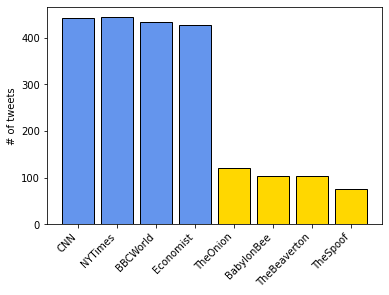

In [8]:
cnn_n = math.floor(np.log2(368200*57100000)*10)
nyt_n = math.floor(np.log2(466100*52200000)*10)
bbc_n = math.floor(np.log2(343400*35400000)*10)
ecn_n = math.floor(np.log2(298400*26400000)*10)
oni_n = math.floor(np.log10(87200*11700000)*10)
bab_n = math.floor(np.log10(18800*1300000)*10)
bev_n = math.floor(np.log10(17100*1299000)*10)
spf_n = math.floor(np.log10(59700*805)*10)
samples = pd.DataFrame([cnn_n, nyt_n, bbc_n, ecn_n, oni_n, bab_n, bev_n, spf_n])
samples.index=['CNN', 'NYTimes', 'BBCWorld', 'Economist', 'TheOnion', 
                 'BabylonBee', 'TheBeaverton', 'TheSpoof' ]
samples.columns = ['n_samples']
fig, ax = plt.subplots(figsize=(6,4))
c = ['cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue',
     'gold','gold','gold','gold']
ax.bar(samples.index, height=samples['n_samples'], edgecolor='k',color = c)
ax.set_ylabel('# of tweets')
plt.setp(ax.get_xticklabels(), Rotation=45, ha='right');

https://www.geeksforgeeks.org/extracting-tweets-containing-a-particular-hashtag-using-python/

### Getting Tweets

In [9]:
# Trusted verified news sources from twitter

# cnn_tweets = get_tweets_with_cache("cnn",1000, keys)
# nytimes_tweets = get_tweets_with_cache("nytimes", 1000, keys)
# bbc_tweets = get_tweets_with_cache("bbcworld",1000, keys)
# theeconomist_tweets = get_tweets_with_cache("theeconomist",1000, keys)

# The parody news accounts

# TheBabylonBee_tweets = get_tweets_with_cache("TheBabylonBee",500, keys)
# TheOnion_tweets = get_tweets_with_cache("TheOnion", 500, keys)
# TheBeaverton_tweets = get_tweets_with_cache("TheBeaverton",500, keys)
# TheSpoof = get_tweets_with_cache("TheSpoof",500, keys)


## WhispersNewsLTD_tweets = get_tweets_with_cache("WhispersNewsLTD",500, keys)

In [10]:
# Looking at one tweet object, which has type Status: 
def make_tweet_df(tweets):
    # Creating DataFrame using pandas
    df = pd.DataFrame(columns=['username', 
                               #'sensitive',
                               'description',
                               'following',
                               'followers',
                               'totaltweets',
                               'created_at', 
                               'text'])
    # not used for now: 'location', #'retweetcount', #'hashtags',
    for t in tweets:
        username = t.user.screen_name
        #sensitive = t.possibly_sensitive
        description = t.user.description
        location = t.user.location
        following = t.user.friends_count
        followers = t.user.followers_count
        totaltweets = t.user.statuses_count
        retweetcount = t.retweet_count
        text = t.text
        time = t.created_at
        #hashtags = t.entities['hashtags']
        #language = t.lang

        ith_tweet = [username, 
                    #sensitive, 
                    description,
                    following, 
                    followers, 
                    totaltweets,
                    time,
                    text, 
                    #language
                     ]
                    #location, #retweetcount, #hashtext 
        df.loc[len(df)] = ith_tweet
    return df


In [28]:
# Create the list of pickle files
file_list = [f for f in os.listdir() if f[-3:]=='pkl']
# the n sample count I chose for each source
sample_counts = [cnn_n, oni_n, bev_n, spf_n, ecn_n, bbc_n, nyt_n, bab_n]
file_list

['cnn_recent_tweets.pkl',
 'TheOnion_recent_tweets.pkl',
 'TheBeaverton_recent_tweets.pkl',
 'TheSpoof_recent_tweets.pkl',
 'theeconomist_recent_tweets.pkl',
 'bbcworld_recent_tweets.pkl',
 'nytimes_recent_tweets.pkl',
 'TheBabylonBee_recent_tweets.pkl']

In [29]:
# Compile into one dataframe
df1 = pd.DataFrame()
for pkl_fil, n_samp in zip(file_list, sample_counts):
    tweets = load_tweets(pkl_fil)
    df2 = make_tweet_df(tweets)[0:n_samp]
    df1 = pd.concat([df1,df2], ignore_index=True)


# Make Data: Corpus, y

In [30]:
# Check the value_counts
df1.username.value_counts()

nytimes          444
CNN              442
BBCWorld         434
TheEconomist     428
TheOnion         120
TheBeaverton     103
TheBabylonBee    103
TheSpoof          76
Name: username, dtype: int64

In [31]:
df1.head()

,username,description,following,followers,totaltweets,created_at,text
0,CNN,It’s our job to #GoThere & tell the most diffi...,1105,57236307,368931,2022-03-23 17:53:03,Senior Vice President of Programs of Mercy Cor...
1,CNN,It’s our job to #GoThere & tell the most diffi...,1105,57236307,368931,2022-03-23 17:52:20,The Supreme Court has rejected a GOP request t...
2,CNN,It’s our job to #GoThere & tell the most diffi...,1105,57236307,368931,2022-03-23 17:37:32,Thousands of people are without power after to...
3,CNN,It’s our job to #GoThere & tell the most diffi...,1105,57236307,368931,2022-03-23 17:35:03,The Biden administration announced that it wil...
4,CNN,It’s our job to #GoThere & tell the most diffi...,1105,57236307,368931,2022-03-23 17:22:05,Brothers George and Melvin DeJesus are out of ...


In [32]:
# checking the number of missing values in the dataset
df1.isnull().sum()

username       0
description    0
following      0
followers      0
totaltweets    0
created_at     0
text           0
dtype: int64

In [33]:
# Create the index for real and fake news sources
ridx = df1.index[df1.username.isin(['CNN', 'BBCWorld', 
                                    'TheEconomist', 'nytimes'])]
fidx = df1.index[~df1.username.isin(['CNN', 'BBCWorld', 
                                    'TheEconomist', 'nytimes'])]     
# Checks the counts                              
print("The parody sources: ", df1.iloc[fidx,:].username.unique())
print("The news sources: ", df1.iloc[ridx,:].username.unique())

# Check back against the usrname key, and the value counts
print('\nParody news souces and counts:\n')
print(df1.iloc[fidx]['username'].value_counts())
print('\nReal news souces and counts:\n')
print(df1.iloc[ridx]['username'].value_counts())

The parody sources:  ['TheOnion' 'TheBeaverton' 'TheSpoof' 'TheBabylonBee']
The news sources:  ['CNN' 'TheEconomist' 'BBCWorld' 'nytimes']

Parody news souces and counts:

TheOnion         120
TheBeaverton     103
TheBabylonBee    103
TheSpoof          76
Name: username, dtype: int64

Real news souces and counts:

nytimes         444
CNN             442
BBCWorld        434
TheEconomist    428
Name: username, dtype: int64


In [34]:
# Create X and y data sets
Corpus = df1.text
y = np.zeros(len(Corpus), int)
y[fidx] = 1
# check the unique counts in y and make sure they 
# coincide with the index created above
noevent_count = np.unique(y, return_counts=True)[1][0]
event_count = np.unique(y, return_counts=True)[1][1]
print(noevent_count == len(ridx))
print(event_count == len(fidx))

True
True


In [35]:
# data & label
# We will look at "Text" and try to estimate
# the binary class 0=real news 1=parody news

print("Corpus length: ", Corpus.shape)
print("y: ", y.shape)
print("Parody news count (1): ", Corpus[fidx].shape)
print("Real news count (0): ", Corpus[ridx].shape)

Corpus length:  (2150,)
y:  (2150,)
Parody news count (1):  (402,)
Real news count (0):  (1748,)


In [22]:
# Split to train and text before any text processing because som involved 
# scaling ie. tf-idf
# Since the class is unbalances, stratify y
from sklearn.model_selection import train_test_split
Corpus_train, Corpus_test, y_train, y_test = train_test_split(Corpus, y, 
                                                    test_size = 0.2,
                                                    stratify=y, random_state=2)

# Text Preprocessing Functions

In [37]:
# Check the value_counts
df1.username.value_counts()

nytimes          444
CNN              442
BBCWorld         434
TheEconomist     428
TheOnion         120
TheBeaverton     103
TheBabylonBee    103
TheSpoof          76
Name: username, dtype: int64

In [38]:
nltk.download('stopwords')
# check stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
# Replace URLs found in a text string with nothing
def remove_url(content):  
    txt2 = [re.sub('http[s]?://\S+','', doc) for doc in content]
    return txt2


# A stemming algorithm is a process of linguistic normalisation, in which the 
# variant forms of a word are reduced to a common form.

port_stem = PorterStemmer()
def stemming(content):
    review = re.sub('[^a-zA-Z]',' ',content)
    review = review.lower()
    review = review.split()
    review = [port_stem.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review

class TFID():
    #Class Constructor 
    def __init__( self, corpus, ngrange, stem_, binary_,
                 normalization, idf, logtf, rem_url):
        self.corpus = corpus
        self.ngrange = ngrange
        self.stem_ = stem_
        self.binary_ = binary_
        self.normalization = normalization
        self.idf = idf
        self.logtf = logtf
        self.rem_url = rem_url
       
    def fit(self, corpus):
        
        # token_pattern is regex to select only alpha (non-numeric) tokens
        TokenPattern = r'\b[a-zA-Z]{2,}\b'
        
        # Remove URLS
        if self.rem_url == True:
            corpus = remove_url(corpus)
        # To apply stemming    
        if self.stem_ == True:
            corpus = pd.Series(corpus).apply(stemming)

        vectorizer = TfidfVectorizer(input='content', 
                                        token_pattern = TokenPattern,
                                        stop_words = stop_words,
                                        binary = self.binary_,
                                        ngram_range = self.ngrange,
                                        use_idf = self.idf,
                                        sublinear_tf = self.logtf,
                                        norm = self.normalization)
        fit = vectorizer.fit(corpus)
        return fit

    def transform(self, fit, corpus):

        # Remove URLS
        if self.rem_url == True:
            corpus = remove_url(corpus)

        # To apply stemming    
        if self.stem_ == True:
            corpus = pd.Series(corpus).apply(stemming)

        X = fit.transform(corpus)
        words = fit.get_feature_names_out()

        # For the term incidence and term frequency dtype is int
        if self.idf==False:
            X = np.array(X.toarray(), dtype='int')
        else:
            X = X.toarray()
        # create Document-Term Matrix / DataFrame
        Xframe = pd.DataFrame(X, columns=words)
        
        return Xframe

# Vectorize Corpus

In [45]:
vectorizer = TFID(corpus=Corpus, ngrange=(1,1), stem_=False, 
                   binary_=False, normalization=False, 
                   idf=False, logtf=False, rem_url=True)

fit = vectorizer.fit(Corpus)
X = vectorizer.transform(fit, Corpus)
# just take the top 3k (more can be taken this is an upper limit)
top3k = X.sum().sort_values(ascending=False)[0:3000].keys()

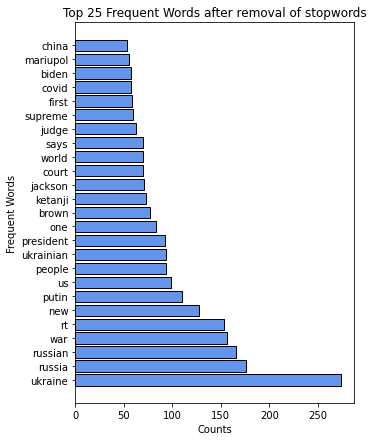

In [46]:
count = X.sum()
fwords = count.sort_values(ascending=False)
plt.figure(figsize=(5,7))
plt.barh(list(range(0,25)), width=fwords[0:25],  
         tick_label=fwords.index[0:25],
         color='cornflowerblue',
         edgecolor='k')
plt.xlabel("Counts")
plt.ylabel("Frequent Words")
plt.title("Top 25 Frequent Words after removal of stopwords");


# plt.savefig('img1.png', dpi=600, transparent=True)

# Model Selection and Evaluation

In [ ]:
svm.SVC().get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [ ]:
# This is for a document - term frequency matrix
transformer = TFID(corpus=Corpus_train, ngrange=(1,1), stem_=True, 
                   binary_=False, normalization=False, 
                   idf=False, logtf=False, rem_url=True)

fit = transformer.fit(Corpus_train)

X_train = transformer.transform(fit, Corpus_train)
X_test = transformer.transform(fit, Corpus_test)
topk = X_train.sum().sort_values(ascending=False)[0:1000].keys()
X_train = X_train[topk]
X_test = X_test[topk]

# create the pipeline 
svm_pipe = Pipeline([  ('svm' , svm.SVC())  ])

# create the parameter grid 
# Pipeline hyper-parameters are specified as <step name>__<hyper-parameter name>

param_grid = {'svm__C': [ 1e-2, 1e-1, 1],
              'svm__kernel': ['linear', 'poly', 'rbf'],
              'svm__degree' : [1,2,3]}

# Instantiate the grid-search
grid = GridSearchCV(svm_pipe, param_grid, cv=5, scoring = 'recall')
# run the grid search are report results 
grid.fit(X_train, y_train)

# print('This was just using gridsearch cv instead, however the scoring is different')
# print('')
# print('Best Parameters')
# print(grid.best_params_)
# print('')
# print('Best validation score')
# print(grid.best_score_)
# print('')
# print('Test Score')
# print(grid.score(X_test, y_test))

GridSearchCV(cv=5, estimator=Pipeline(steps=[('svm', SVC())]),
             param_grid={'svm__C': [0.01, 0.1, 1], 'svm__degree': [1, 2, 3],
                         'svm__kernel': ['linear', 'poly', 'rbf']},
             scoring='recall')

In [ ]:
print('Results of Gridsearch CV')
print('')
print('Best Parameters')
print(grid.best_params_)
print('')
print('Best validation score')
print(grid.best_score_)
print('')
print('Test Score')
print(grid.score(X_test, y_test))

Results of Gridsearch CV

Best Parameters
{'svm__C': 1, 'svm__degree': 1, 'svm__kernel': 'linear'}

Best validation score
0.6005967604433078

Test Score
0.5465116279069767


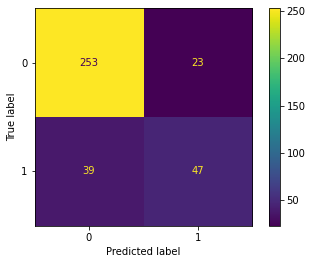

In [ ]:
y_hat = grid.predict(X_test)
cm = confusion_matrix(y_test, y_hat, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid.classes_)
tn, fp, fn, tp = cm.ravel()
recall = tp/(tp+fn)
precision = tp/(tp+fp)
acc = (tp+tn)/(tn+ fp+ fn+ tp)

disp.plot()

In [ ]:
precision

0.6714285714285714